# Imports

In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
%config InlineBackend.figure_format = 'svg'

import deepinv as dinv
from functools import partial
from time import time
import math

import numpy as np
import pandas as pd
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import entropy
from tqdm import tqdm

from deepinv.utils.demo import load_url_image
from deepinv.utils.plotting import plot
from deepinv.optim.phase_retrieval import cosine_similarity, spectral_methods, plot_error_bars, generate_signal
from deepinv.physics.phase_retrieval import StructuredRandomPhaseRetrieval
from deepinv.physics.structured_random import MarchenkoPastur

In [3]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 32491 MiB free memory 


device(type='cuda', index=0)

# Time complexity

In [ ]:
# img_sizes: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 256]
img_sizes: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
print(img_sizes)
n_repeats = 100
oversampling = 1

In [ ]:
device = torch.device("cuda",index=0)
device

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# works well if not in class
foo = torch.randn((240**2, 240**2), device=device, dtype=torch.complex64)
bar = foo

In [ ]:
physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*240**2),
            img_shape= (1, 240, 240),
            dtype = torch.complex64,
            device=device,
            test=True,
        )

In [ ]:
physics.release_memory()

In [ ]:
# random model

df_random_gpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    torch.cuda.empty_cache()
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device)
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)
    torch.cuda.synchronize()
    for i in range(n_repeats):
        physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*torch.prod(torch.tensor(x.shape))),
            img_shape= (1, img_size, img_size),
            dtype = torch.complex64,
            device=device,
            test=True,
        )
        torch.cuda.synchronize()
        init_time = time()
        y = physics.forward(x_phase)
        torch.cuda.synchronize()
        df_random_gpu.loc[i, f"img_size_{img_size}"] = time() - init_time
        physics.release_memory()
        torch.cuda.empty_cache()
        print("allocated memory after clearing cache", torch.cuda.memory_allocated(device)/1024**2,"MB")

In [ ]:
df_random_gpu.to_csv("df_random_gpu.csv", index=False)
df_random_gpu

In [ ]:
# structured model
df_structured_gpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    img_size = img_size
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device)
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

    torch.cuda.synchronize()
    for i in range(n_repeats):
        physics = dinv.physics.StructuredRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
            dtype = torch.complex64,
            device=device,
        )
        init_time = time()
        torch.cuda.synchronize()
        y = physics.forward(x_phase)
        df_structured_gpu.loc[i, f"img_size_{img_size}"] = time() - init_time
        torch.cuda.synchronize()
        physics.release_memory()
        torch.cuda.synchronize()

In [ ]:
df_structured_gpu.to_csv("paper/data/time/df_structured_gpu.csv", index=False)
df_structured_gpu

In [ ]:
device = 'cpu'

In [ ]:
# random model
df_random_cpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device='cpu')
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to('cpu')

    for i in range(n_repeats):
        physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*torch.prod(torch.tensor(x.shape))),
            img_shape= (1, img_size, img_size),
            dtype = torch.complex64,
            device='cpu',
        )
        init_time = time()
        y = physics.forward(x_phase)
        df_random_cpu.loc[i, f"img_size_{img_size}"] = time() - init_time

In [ ]:
# structured model
df_structured_cpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    img_size = img_size
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device='cpu')
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to('cpu')

    for i in range(n_repeats):
        physics = dinv.physics.StructuredRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
            dtype = torch.complex64,
            device='cpu',
        )
        init_time = time()
        y = physics.forward(x_phase)
        df_structured_cpu.loc[i, f"img_size_{img_size}"] = time() - init_time

In [ ]:
df_structured_cpu.to_csv("paper/data/time/df_structured_cpu.csv", index=False)
df_structured_cpu.mean(axis=0)

In [ ]:
pixels = [i**2 for i in img_sizes]

In [ ]:
# plt.plot(pixels,df_random_cpu.mean(axis=0),label='Random (CPU)')
# plt.plot(pixels,df_random_gpu.mean(axis=0),label='Random (GPU)')
plt.plot(pixels,df_structured_cpu.mean(axis=0),label='structured (CPU)')
plt.plot(pixels,df_structured_gpu.mean(axis=0),label='structured (GPU)')
plt.xlabel('Image size (pixels)')
plt.ylabel('Forward time (s)')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Time Complexity of Forward Model')
plt.legend()
plt.savefig('time.svg')
plt.show()

In [ ]:
# save data
df_random_cpu.to_csv('df_random_cpu.csv')
df_random_gpu.to_csv('df_random_gpu.csv')
df_structured_cpu.to_csv('df_structured_cpu.csv')
df_structured_gpu.to_csv('df_structured_gpu.csv')

In [ ]:
plot_error_bars([pixels] * 4,
                [df_random_cpu, df_random_gpu, df_structured_cpu, df_structured_gpu],
                ['Random (CPU)', 'Random (GPU)', 'structured (CPU)', 'structured (GPU)'],
                title = f'Forward time (s) vs Image size (oversampling={oversampling})',
                xlabel = 'Image size',
                xscale = 'log',
                ylabel = 'Forward time (s)',
                yscale = 'log',
                axis = 0)

# Test playground for images

## Empirical Entropy of Images with Different Noise Levels

In [ ]:
def empirical_entropy(data, bins):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)  # Histogram with density=True normalizes the data
    p = hist / hist.sum()  # Convert histogram counts to probabilities
    return entropy(p, base=2)  # Compute Shannon entropy

In [ ]:
config = DotMap()
config.img_size = 64
config.mode = 'shepp-logan'
config.noise_ratio = 0.4
config.varying_norm = False
config.unit_mag = True

imgs = []
for i in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    config.noise_ratio = i
    x = generate_signal(
        config.img_size,
        config.mode,
        transform='noise',
        config=config,
        dtype=torch.complex64
    )
    imgs.append(x.angle())
plot(imgs)

# Create a figure with 1 row and 5 columns of subplots
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

# Iterate over the axes to plot on each subplot
for i, ax in enumerate(axes):
    ax.hist(imgs[i].flatten(), bins=10)  # Example plot
    H = empirical_entropy(imgs[i], bins=10)
    print("entropy:", H, "variance:", imgs[i].var().numpy())

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
x = generate_signal(
    shape = (1, 64, 64),
    mode = ['delta','constant'],
)

plot(x.abs())

# i.i.d. random model

In [ ]:
input_size = 64
output_size = 48

oversampling = 3.0

physics = dinv.physics.RandomPhaseRetrieval(
    m=output_size**2,
    img_shape=(1, input_size, input_size),
    product=1,
    dtype=torch.complex64,
    device=device,
)

In [ ]:
physics.B._A.shape

In [ ]:
spectrum = torch.linalg.svdvals(physics.B._A)
spectrum = spectrum[torch.randperm(spectrum.numel())]
spectrum.shape

# Nelder-Mead Method to Optimize Spectrum

In [ ]:
def find_specturm_frequencies(input_shape,output_shape, n_bins=20, n_samples=100000):
    # given an oversampling ratio, get the histgram of the marchenko pastur distribution by sampling.
    # return the edges of the bins and the frequencies normalized to sum to 1
    distribution = MarchenkoPastur(m=np.prod(output_shape), n=np.prod(input_shape))
    samples = distribution.sample(n_samples)
    hist, bin_edges = np.histogram(samples, bins=n_bins, density=False)
    hist = hist / hist.sum()
    hist = np.log(hist)
    return hist, bin_edges

def sample_diagonal(hist, bin_edges, shape):
    # given the unsoftmaxed histogram and the bin edges, sample from the distribution assuming every bin is a uniform distribution
    assert hist.shape[0] == bin_edges.shape[0] - 1, "shapes of histogram and bin edges don't match"
    probabilities = sp.special.softmax(hist)
    # Step 1: Choose bins based on probabilities
    chosen_bins = np.random.choice(len(probabilities), size=np.prod(shape), p=probabilities)
    # Step 2: Sample uniformly within the chosen bin
    samples = np.empty(np.prod(shape))
    for i, bin_index in enumerate(chosen_bins):
        left_edge = bin_edges[bin_index]
        right_edge = bin_edges[bin_index + 1]
        samples[i] = np.random.uniform(left_edge, right_edge)
    
    return samples.reshape(shape)

def loss(x,
         bin_edges,
         input_shape,
         output_shape,
         n_repeats=10,
         device = 'cpu'):
    # given a decision x representing the histogram, sample from the distribution and compute the loss as average cosine similarity obstained by spectral methods
    score = 0

    img = generate_signal(
        img_size=input_shape[-1],
        mode='shepp-logan',
        transform=None,
        config={'unit_mag':True},
        device=device,
    )

    for _ in range(n_repeats):
        samples = sample_diagonal(x, bin_edges, output_shape)
        diagonal = torch.tensor(samples, dtype=torch.complex64)
        physics = StructuredRandomPhaseRetrieval(
            input_shape=input_shape,
            output_shape=output_shape,
            n_layers=2,
            diagonals=[['custom','uniform'],['unit','uniform']],
            diagonal_config={'diagonal':diagonal},
            device=device,
        )
        y = physics(img)
        x_spec = spectral_methods(y, physics, verbose=False)
        score += cosine_similarity(x_spec, img)
    
    # score larger better
    print("current average cosine similarity:", (score / n_repeats).item())
    return (- score / n_repeats).item()

In [ ]:
input_shape = (1,64,64)
output_shape = (1,78,78)
n_bins = 30

hist, bin_edges = find_specturm_frequencies(input_shape=input_shape, output_shape=output_shape, n_bins=n_bins, n_samples=100000)

samples = sample_diagonal(hist, bin_edges, shape=output_shape)

loss_func = partial(loss, bin_edges=bin_edges, input_shape=input_shape, output_shape=output_shape, n_repeats=10, device=device)

In [ ]:
solution = sp.optimize.minimize(fun=loss_func, x0=hist, method='Nelder-Mead', options={'maxiter': 1000})

# Machenko-Pastur Distribution

In [4]:
m = 70**2
n = 64**2

In [5]:
# Parameters
sigma = 1 / np.sqrt(m)
sqrt_n = int(np.sqrt(n))
n_bins = 25
# reciprocal of oversampling ratio
gamma = n / m
# oversampling ratio
lamb = m / n
min_supp = sigma**2*(1-np.sqrt(gamma))**2
max_supp = sigma**2*(1+np.sqrt(gamma))**2

# 4. random phase retrieval
physics = dinv.physics.RandomPhaseRetrieval(
    m = m,
    img_shape= (1, sqrt_n, sqrt_n),
    dtype = torch.complex64,
    device=device,
)
eigenvalues_A, eigenvectors_A = torch.linalg.eig(physics.B._A.conj().T@physics.B._A)

In [6]:
import torch.nn.functional as F
# 3. diagonal
marchenko = MarchenkoPastur(m,n)
diagonal = torch.from_numpy(marchenko.sample((1, 64, 64))).flatten()

# Reshape the tensor to shape (n, 8) and sample one element from each group of 8
# indices = torch.randint(0, 16, (n,))  # Random indices within each group of 8
# diagonal = diagonal.view(n, 16)[torch.arange(n), indices]

In [7]:
diagonal = diagonal[torch.where(diagonal.abs() > 1e-5)]
eigenvalues_A = eigenvalues_A[torch.where(eigenvalues_A.abs() > 1e-5)]

In [8]:
frequencies, bin_edges = np.histogram(diagonal, bins=20)

In [9]:
frequencies

array([ 90, 137, 193, 192, 217, 214, 243, 268, 266, 278, 249, 257, 250,
       242, 224, 223, 187, 160, 132,  74])

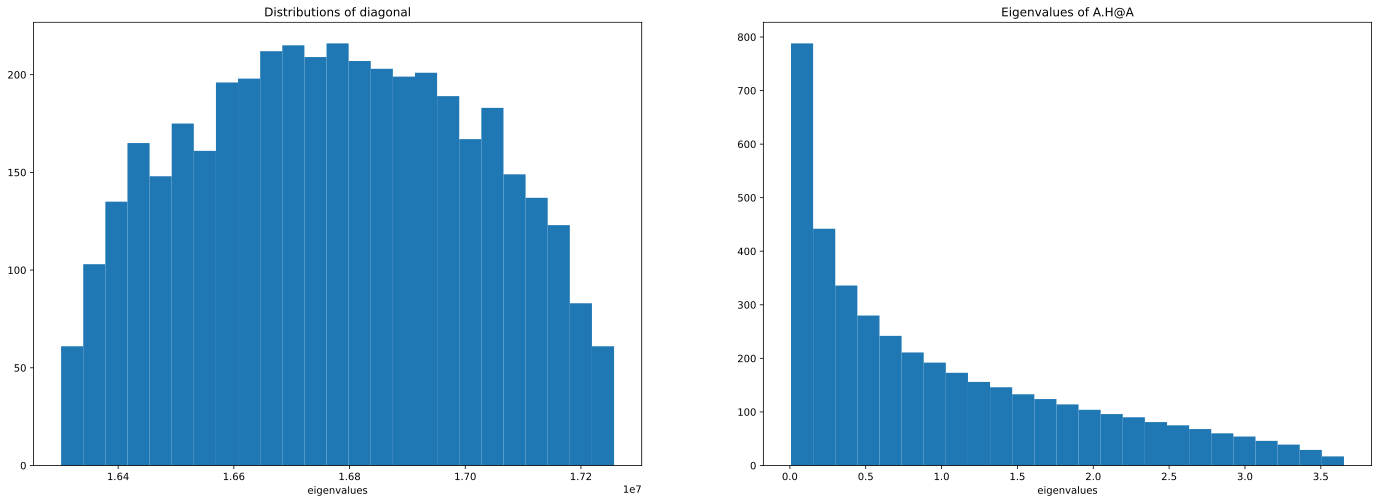

In [10]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].hist((diagonal).abs().flatten().cpu(), bins=n_bins);
ax[0].set_xlabel('eigenvalues')
ax[0].set_title('Distributions of diagonal')
ax[1].hist(eigenvalues_A.abs().flatten().cpu(), bins=n_bins);
ax[1].set_xlabel('eigenvalues')
ax[1].set_title('Eigenvalues of A.H@A')

plt.show()

# Test playground for structured random model

In [ ]:
img_shape = (1, 1, 64, 64)
mode = ['unit','shepp-logan']

x = generate_signal(
    shape=img_shape,
    mode=mode,
    transform=None,
    phase_range=[-np.pi/2, np.pi/2],
    dtype=torch.complex64,
    device=device,
)

plot(x.angle())

In [ ]:
input_size = 64
output_size = 90

physics = dinv.physics.StructuredRandomPhaseRetrieval(
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    n_layers=2,
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transforms=["fourier2","hadamard1"],
    dtype=torch.complex64,
    device=device,
)
print("physics structure:", physics.structure)

In [ ]:
delta = generate_signal(
    shape=(1, 1, 90, 90),
    mode=['delta','constant'],
    dtype=torch.complex64,
    device=device,
)

adversarial = physics.get_adversarial(n_layers=1,trimmed=True)
adversarial.shape

In [ ]:
y_normal = physics(x)
y_adversarial = physics(adversarial*10)

In [ ]:
plot(adversarial.angle())

In [ ]:
x_recon = spectral_methods(y_normal, physics, n_iter=3000)
x_adversarial_recon = spectral_methods(y_adversarial, physics, n_iter=3000)

print("cosine similarity normal:", cosine_similarity(x_recon, x))
print("cosine similarity adversarial:", cosine_similarity(x_adversarial_recon, adversarial))

# Adversarial Input

In [4]:
input_size = 64
output_size = 128
n_layers = 5

physics = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=n_layers,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"],["unit","uniform"],["unit","uniform"],["marchenko","uniform"]],
    transforms=["cosine1"]*5,
    dtype=torch.complex64,
    device=device,
)
print("physics structure:", physics.structure)

physics structure: FDFDFDFDFD


In [5]:
adv_layer = 3
adver = physics.get_adversarial(n_layers=adv_layer,trimmed=True, mag='delta')
adver.shape

torch.Size([1, 1, 64, 64])

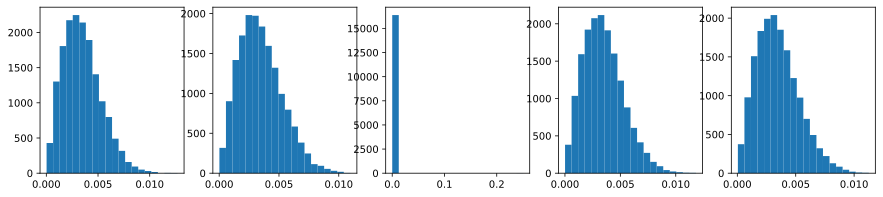

In [6]:
n_layer = physics.n_layers
# subplot showing the magnitude the measurement after every layer
fig, axes = plt.subplots(1, n_layer, figsize=(3*n_layer, 3))
for i in range(n_layer):
    axes[i].hist(physics.partial_forward(adver, i+1).abs().flatten().cpu(), bins=20)
fig.show()

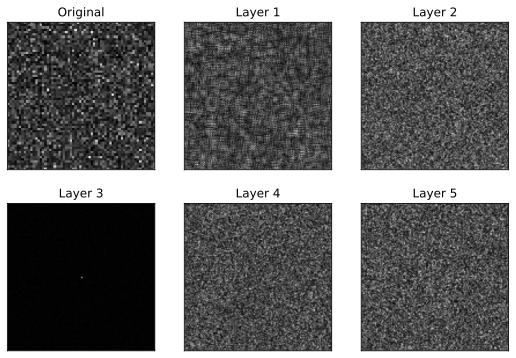

In [7]:
measurements = [adver.abs().cpu()]

for i in range(n_layers):
    measurements.append(physics.partial_forward(adver, i+1).abs().cpu())

labels = ['Original']
for i in range(n_layers):
    labels.append(f"Layer {i+1}")

measurements[2] = np.fft.fftshift(measurements[2], axes=(-2, -1))

# plot a 2 by 3 subplot showing the magnitude the measurement after every layer with the labels
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i in range(n_layers+1):
    axes[i//3, i%3].imshow(measurements[i][0,0,:,:],cmap='grey')
    axes[i//3, i%3].set_title(labels[i])
    axes[i//3, i%3].set_xticks([])
    axes[i//3, i%3].set_yticks([])
plt.savefig("../figures/adver-viz.pdf")
fig.show()

In [60]:
measurements[2][0,0,:,:].cpu()

tensor([[30.6350,  0.6650,  0.5575,  ...,  0.2248,  0.6479,  0.6909],
        [ 0.5862,  0.4596,  0.5858,  ...,  0.4917,  0.6652,  0.1599],
        [ 0.1045,  0.3653,  0.6342,  ...,  0.7453,  0.3591,  0.4496],
        ...,
        [ 0.4733,  0.3638,  0.2634,  ...,  0.5450,  0.0957,  0.2310],
        [ 0.0511,  0.5969,  0.4680,  ...,  0.3403,  0.6694,  0.2495],
        [ 0.6088,  0.3202,  0.6767,  ...,  0.5795,  0.4979,  0.4356]])

In [ ]:
print(measurements[-1].abs().max())
measurements[-1]

In [ ]:
adver_spec = spectral_methods(physics(adver), physics, n_iter=3000)
print("cosine similarity:", cosine_similarity(adver_spec, adver))
plot(adver_spec.angle())

# Spectrum of Forward Matrix

## Oversampling unitray matrices

In [ ]:
input_size = 64
output_size = 90

In [ ]:
unitary = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

unitary_fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

unitary_dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

unitary_hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_unitary = unitary.B.get_singular_values()
s_unitary_fft_padded = unitary_fft_padded.B.get_singular_values()
s_unitary_dct_padded = unitary_dct_padded.B.get_singular_values()
s_unitary_hadamard_padded = unitary_hadamard_padded.B.get_singular_values()

In [ ]:
mpl.rcParams.update({'font.size': 8})
# two figures plotting the histogram of two spectrum
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0,0].hist(s_unitary, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values of U')
ax[0,1].hist(s_unitary_fft_padded, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values of fft padded')
ax[1,0].hist(s_unitary_dct_padded, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values of dct padded')
ax[1,1].hist(s_unitary_hadamard_padded, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values of hadamard (padded)')
fig.suptitle('Singular values of U and U padded')
plt.show()

## Oversampling Marchenko matrices, right diagonal

In [ ]:
iid = dinv.physics.RandomPhaseRetrieval(
    m=int(output_size**2),
    img_shape=(1, input_size, input_size),
    dtype=torch.complex64,
    device=device,
)

marchenko = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_iid = sp.linalg.svdvals(iid.B._A.cpu().numpy())
s_marchenko = marchenko.B.get_singular_values()
s_fft_padded = fft_padded.B.get_singular_values()
s_dct_padded = dct_padded.B.get_singular_values()
s_hadamard_padded = hadamard_padded.B.get_singular_values()

In [ ]:
# plotting the histogram of the spectrum
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0,0].hist(s_iid**2, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values squared of iid')
ax[0,1].hist(s_marchenko**2, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values squared of Marchenko')
ax[0,2].hist(s_fft_padded**2, bins=20);
ax[0,2].set_xlabel('singular values')
ax[0,2].set_title('Singular values squared of FFT padded')
ax[1,0].hist(s_dct_padded**2, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values squared of DCT padded')
ax[1,1].hist(s_hadamard_padded**2, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values squared of Hadamard (padded)')
fig.suptitle('Singular values squared of four transforms')
plt.show()

## Oversampling Marchenko matrices, left diagonal

In [ ]:
iid = dinv.physics.RandomPhaseRetrieval(
    m=int(output_size**2),
    img_shape=(1, input_size, input_size),
    dtype=torch.complex64,
    device=device,
)

marchenko = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_iid = sp.linalg.svdvals(iid.B._A.cpu().numpy())
s_marchenko = marchenko.B.get_singular_values()
s_fft_padded = fft_padded.B.get_singular_values()
s_dct_padded = dct_padded.B.get_singular_values()
s_hadamard_padded = hadamard_padded.B.get_singular_values()

In [ ]:
# plotting the histogram of the spectrum
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0,0].hist(s_iid**2, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values squared of iid')
ax[0,1].hist(s_marchenko**2, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values squared of Marchenko')
ax[0,2].hist(s_fft_padded**2, bins=20);
ax[0,2].set_xlabel('singular values')
ax[0,2].set_title('Singular values squared of FFT padded')
ax[1,0].hist(s_dct_padded**2, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values squared of DCT padded')
ax[1,1].hist(s_hadamard_padded**2, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values squared of Hadamard (padded)')
fig.suptitle('Singular values squared of four transforms')
plt.show()

## Subsampling unitary matrices

In [ ]:
input_size = 64
output_size = 40

In [ ]:
unitary = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

unitary_fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

unitary_dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

unitary_hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_unitary = unitary.B.get_singular_values()
s_unitary_fft_padded = unitary_fft_padded.B.get_singular_values()
s_unitary_dct_padded = unitary_dct_padded.B.get_singular_values()
s_unitary_hadamard_padded = unitary_hadamard_padded.B.get_singular_values()

In [ ]:
mpl.rcParams.update({'font.size': 8})
# two figures plotting the histogram of two spectrum
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0,0].hist(s_unitary, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values of U')
ax[0,1].hist(s_unitary_fft_padded, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values of fft padded')
ax[1,0].hist(s_unitary_dct_padded, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values of dct padded')
ax[1,1].hist(s_unitary_hadamard_padded, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values of hadamard (padded)')
fig.suptitle('Singular values of U and U padded')
plt.show()

## Subsampling Marchenko matrices, right diagonal

In [ ]:
iid = dinv.physics.RandomPhaseRetrieval(
    m=int(output_size**2),
    img_shape=(1, input_size, input_size),
    dtype=torch.complex64,
    device=device,
)

marchenko = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_iid = sp.linalg.svdvals(iid.B._A.cpu().numpy())
s_marchenko = marchenko.B.get_singular_values()
s_fft_padded = fft_padded.B.get_singular_values()
s_dct_padded = dct_padded.B.get_singular_values()
s_hadamard_padded = hadamard_padded.B.get_singular_values()

In [ ]:
# four figures plotting the histogram of four spectrum
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0,0].hist(s_iid, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values squared of iid')
ax[0,1].hist(s_marchenko**2, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values squared of FFT unpadded')
ax[0,2].hist(s_fft_padded**2, bins=20);
ax[0,2].set_xlabel('singular values')
ax[0,2].set_title('Singular values squared of FFT padded')
ax[1,0].hist(s_dct_padded**2, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values squared of DCT padded')
ax[1,1].hist(s_hadamard_padded**2, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values squared of Hadamard (padded)')
fig.suptitle('Singular values squared of four transforms')
plt.show()

## Subsampling Marchenko matrices, left diagonal

In [ ]:
iid = dinv.physics.RandomPhaseRetrieval(
    m=int(output_size**2),
    img_shape=(1, input_size, input_size),
    dtype=torch.complex64,
    device=device,
)

marchenko = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_iid = sp.linalg.svdvals(iid.B._A.cpu().numpy())
s_marchenko = marchenko.B.get_singular_values()
s_fft_padded = fft_padded.B.get_singular_values()
s_dct_padded = dct_padded.B.get_singular_values()
s_hadamard_padded = hadamard_padded.B.get_singular_values()

In [ ]:
# four figures plotting the histogram of four spectrum
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0,0].hist(s_iid, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values squared of iid')
ax[0,1].hist(s_marchenko**2, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values squared of Marchenko')
ax[0,2].hist(s_fft_padded**2, bins=20);
ax[0,2].set_xlabel('singular values')
ax[0,2].set_title('Singular values squared of FFT padded')
ax[1,0].hist(s_dct_padded**2, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values squared of DCT padded')
ax[1,1].hist(s_hadamard_padded**2, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values squared of Hadamard (padded)')
fig.suptitle('Singular values squared of four transforms')
plt.show()

## Subsampling Marchenko matrices, using distribution for oversampling 1

In [ ]:
iid = dinv.physics.RandomPhaseRetrieval(
    m=int(output_size**2),
    img_shape=(1, input_size, input_size),
    dtype=torch.complex64,
    device=device,
)

marchenko = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_iid = sp.linalg.svdvals(iid.B._A.cpu().numpy())
s_marchenko = marchenko.B.get_singular_values()
s_fft_padded = fft_padded.B.get_singular_values()
s_dct_padded = dct_padded.B.get_singular_values()
s_hadamard_padded = hadamard_padded.B.get_singular_values()

In [ ]:
# four figures plotting the histogram of four spectrum
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0,0].hist(s_iid, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values squared of iid')
ax[0,1].hist(s_marchenko**2, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values squared of Marchenko')
ax[0,2].hist(s_fft_padded**2, bins=20);
ax[0,2].set_xlabel('singular values')
ax[0,2].set_title('Singular values squared of FFT padded')
ax[1,0].hist(s_dct_padded**2, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values squared of DCT padded')
ax[1,1].hist(s_hadamard_padded**2, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values squared of Hadamard (padded)')
fig.suptitle('Singular values squared of four transforms')
plt.show()

## Marchenko Hadamard oversampling close to 1

In [ ]:
hadamard_1 = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, 64, 64),
    output_shape=(1, 62, 62),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="hadamard2",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_2 = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, 64, 64),
    output_shape=(1, 66, 66),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="hadamard2",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

fft_1 = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, 64, 64),
    output_shape=(1, 62, 62),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fourier2",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

fft_2 = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, 64, 64),
    output_shape=(1, 66, 66),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fourier2",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_hadamard1 = hadamard_1.get_singular_values()
s_hadamard2 = hadamard_2.get_singular_values()
s_fft1 = fft_1.get_singular_values()
s_fft2 = fft_2.get_singular_values()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0,0].hist(s_hadamard1**2, bins=20);
ax[0,0].set_xlabel('singular values squared')
ax[0,0].set_title('Hadamard 0.94')
ax[0,1].hist(s_hadamard2**2, bins=20);
ax[0,1].set_xlabel('singular values squared')
ax[0,1].set_title('Hadamard 1.06')
ax[1,0].hist(s_fft1**2, bins=20);
ax[1,0].set_xlabel('singular values squared')
ax[1,0].set_title('FFT 0.94')
ax[1,1].hist(s_fft2**2, bins=20);
ax[1,1].set_xlabel('singular values squared')
ax[1,1].set_title('FFT 1.06')
fig.suptitle('Singular values squared')
plt.show()

# Sample Covriance Computation

In [8]:
def compute_sample_covariance_structured_random(
    n_layers = 1,
    size = 2,
    n_samples = 1000,
    transform = "fourier2",
    device = 'cpu',
):
    """ Given a n_layers configuration, compute the sample covariance matrix of the elements of the forward matrix of the structured random model."""
    matrices = torch.empty(n_samples, size**4, dtype=torch.complex64, device=device)
    for i in range(n_samples):
        physics = dinv.physics.StructuredRandomPhaseRetrieval(
            input_shape=(1, size, size),
            output_shape=(1, size, size),
            n_layers=n_layers,
            diagonals=[["unit","uniform"]] * int(np.floor(n_layers)),
            transforms=[transform] * int(np.ceil(n_layers)),
            explicit_matrix=True,
            dtype=torch.complex64,
            device=device,
        )
        matrices[i] = physics.get_forward_matrix().flatten()
    # sample mean
    mean = matrices.mean(dim=0)
    # sample covariance
    covariance = torch.einsum('ij,ik->jk', matrices-mean, (matrices-mean).conj())/(n_samples-1)
    return covariance

In [9]:
def compute_sample_covariance_circulant(
    size,
    n_samples = 1000,
    device = 'cpu'
):
    """ Compute the sample covariance matrix of the elements of the left circulant matrix."""
    matrices = torch.empty(n_samples, size**2, dtype=torch.complex64, device=device)
    for i in range(n_samples):
        row = torch.randn(size, device=device)
        matrix = torch.zeros((size, size))
        for j in range(size):
            # Shift vector left by i positions
            shifted = torch.roll(row, shifts=-j)
            matrix[j] = shifted
        matrices[i] = matrix.flatten()
    # sample mean
    mean = matrices.mean(dim=0)
    # sample covariance
    covariance = torch.einsum('ij,ik->jk', matrices-mean, (matrices-mean).conj())/(n_samples-1)
    return covariance

In [10]:
size = 2
n_samples = 10000

In [11]:
covariance_1_fourier = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_1_cosine = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_1_hadamard = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="hadamard2", device=device)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,36))
im1 = axes[0].matshow(covariance_1_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Fourier")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_1_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Cosine")
fig.colorbar(im2, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_1_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Hadamard")
fig.colorbar(im3, ax=axes[2], shrink=0.06)
plt.savefig("../figures/covariance_1.pdf",transparent=True, bbox_inches='tight')
plt.show()

In [12]:
covariance_1p5_fourier = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_1p5_cosine = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_1p5_hadamard = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="hadamard2", device=device)
covariance_circulant = compute_sample_covariance_circulant(size=size**2, n_samples=n_samples, device=device)

In [9]:
covariance_2_fourier = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_2_cosine = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_2_hadamard = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="hadamard2", device=device)

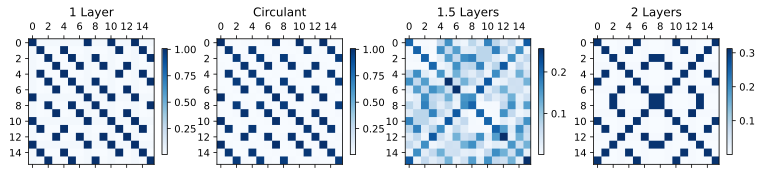

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(13,48))
im1 = axes[0].matshow(covariance_circulant.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Circulant")
fig.colorbar(im1, ax=axes[0], shrink=0.04)
im2 = axes[1].matshow(covariance_1p5_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Fourier")
fig.colorbar(im1, ax=axes[1], shrink=0.04)
im3 = axes[2].matshow(covariance_1p5_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Cosine")
fig.colorbar(im2, ax=axes[2], shrink=0.04)
im4 = axes[3].matshow(covariance_1p5_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[3].set_title("Hadamard")
fig.colorbar(im3, ax=axes[3], shrink=0.04)
plt.savefig("../figures/covariance-1p5.pdf",transparent=True, bbox_inches='tight')
plt.show()

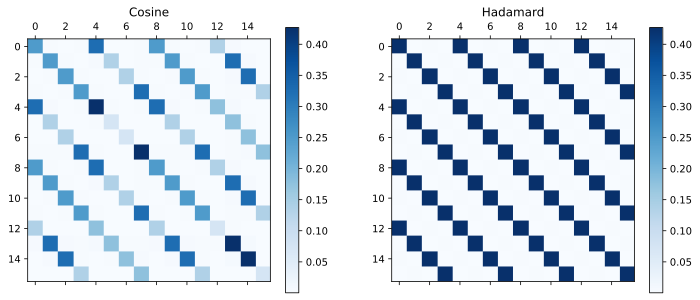

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 24))
im1 = axes[0].matshow(covariance_1_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Cosine")
fig.colorbar(im1, ax=axes[0], shrink=0.2)
im2 = axes[1].matshow(covariance_1_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Hadamard")
fig.colorbar(im1, ax=axes[1], shrink=0.2)
plt.savefig("../figures/covariance_supp_1.pdf",transparent=True, bbox_inches='tight')
plt.show()

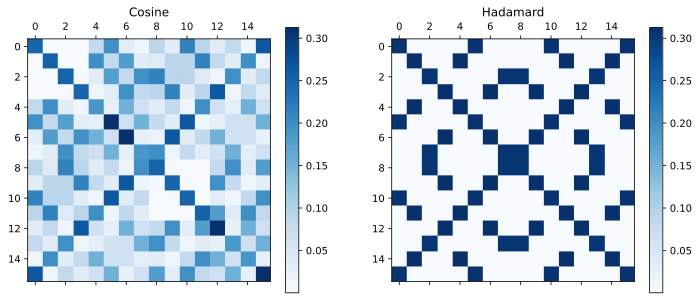

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 24))
im1 = axes[0].matshow(covariance_1p5_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Cosine")
fig.colorbar(im1, ax=axes[0], shrink=0.2)
im2 = axes[1].matshow(covariance_1p5_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Hadamard")
fig.colorbar(im1, ax=axes[1], shrink=0.2)
plt.savefig("../figures/covariance_supp_1p5.pdf",transparent=True, bbox_inches='tight')
plt.show()

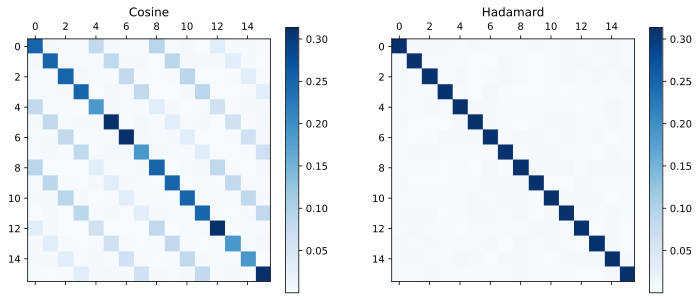

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 24))
im1 = axes[0].matshow(covariance_2_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Cosine")
fig.colorbar(im1, ax=axes[0], shrink=0.2)
im2 = axes[1].matshow(covariance_2_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Hadamard")
fig.colorbar(im1, ax=axes[1], shrink=0.2)
plt.savefig("../figures/covariance_supp_2.pdf",transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
covar = covariance_2_cosine.abs()
print(covar.diagonal().min())
for i in range(covar.shape[0]):
    covar[i,i] = 0
print(covar.max())

In [ ]:
size = 2
n_samples = 10000

In [ ]:
covariance_1_fourier = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_1_cosine = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_1_hadamard = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="hadamard2", device=device)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,36))
im1 = axes[0].matshow(covariance_1_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Fourier")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_1_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Cosine")
fig.colorbar(im2, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_1_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Hadamard")
fig.colorbar(im3, ax=axes[2], shrink=0.06)
plt.show()

In [ ]:
covariance_1p5_fourier = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_1p5_cosine = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_1p5_hadamard = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="hadamard2", device=device)
covariance_circulant = compute_sample_covariance_circulant(size=size**2, n_samples=n_samples, device=device)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12,48))
im1 = axes[0].matshow(covariance_circulant.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Circulant")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_1p5_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Fourier")
fig.colorbar(im1, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_1p5_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Cosine")
fig.colorbar(im2, ax=axes[2], shrink=0.06)
im4 = axes[3].matshow(covariance_1p5_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[3].set_title("Hadamard")
fig.colorbar(im3, ax=axes[3], shrink=0.06)
plt.show()

In [ ]:
covariance_2_fourier = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_2_cosine = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_2_hadamard = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="hadamard2", device=device)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,36))
im1 = axes[0].matshow(covariance_2_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Fourier")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_2_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Cosine")
fig.colorbar(im2, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_2_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Hadamard")
fig.colorbar(im3, ax=axes[2], shrink=0.06)
plt.show()

In [ ]:
covariance_3_fourier = compute_sample_covariance_structured_random(n_layers=3, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_3_cosine = compute_sample_covariance_structured_random(n_layers=3, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_3_hadamard = compute_sample_covariance_structured_random(n_layers=3, size=size, n_samples=n_samples, transform="hadamard2", device=device)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,36))
im1 = axes[0].matshow(covariance_3_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Fourier")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_3_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Cosine")
fig.colorbar(im2, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_3_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Hadamard")
fig.colorbar(im3, ax=axes[2], shrink=0.06)
plt.show()

In [ ]:
size = 64
n_layers = 1.5
physics = dinv.physics.StructuredRandomPhaseRetrieval(
    input_shape=(1, size, size),
    output_shape=(1, size, size),
    n_layers=n_layers,
    diagonals=[["unit","uniform"]] * int(np.floor(n_layers)),
    transforms=["fourier2"] * int(np.ceil(n_layers)),
    explicit_matrix=True,
    dtype=torch.complex64,
    device=device,
)

In [ ]:
matrix = physics.get_forward_matrix().to('cpu').numpy()
matrix.shape

In [ ]:
matrix.real.flatten().shape

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(matrix.real.flatten(), matrix.imag.flatten(), color='b', marker='o', label='Matrix Elements', s=0.1)
plt.axhline(0, color='black', linewidth=0.5)  # Real axis
plt.axvline(0, color='black', linewidth=0.5)  # Imaginary axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Complex Matrix Elements on Complex Plane")
plt.legend()
plt.show()

In [ ]:
# histogram of real part
plt.figure(figsize=(6, 6))
plt.hist(matrix.real.flatten(), bins=100, color='b', alpha=0.5, label='Real Part')
plt.xlabel("Real Part")
plt.ylabel("Frequency")
plt.title("Histogram of Real Part")
plt.legend()
plt.show()

In [ ]:
# histogram of imaginary part
plt.figure(figsize=(6, 6))
plt.hist(matrix.imag.flatten(), bins=100, color='b', alpha=0.5, label='Imaginary Part')
plt.xlabel("Imaginary Part")
plt.ylabel("Frequency")
plt.title("Histogram of Imaginary Part")
plt.legend()
plt.show()